In [29]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import scipy.io as scio
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [30]:
def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)

seed = 42
seed_all(seed)

In [31]:
# 输入特征的读取
feature_path = "AWA2/split/res101.mat"
feature_data = scio.loadmat(feature_path)
features = feature_data['features'].transpose(1,0)
labels = feature_data['labels'].reshape(-1)

# {类label:类名}字典读取
classes_path = 'AWA2/classes.txt'
# key is label name, value is label id
class_dict = pd.read_csv(classes_path, sep='\t', header=None).set_index(1)[0].to_dict()

# 训练/验证类label读取
trainval_classes_path = 'AWA2/split/trainvalclasses.txt'
trainval_names = pd.read_csv(trainval_classes_path, header=None)[0].to_list()
trainval_values = [class_dict[name] for name in trainval_names]

# 测试类label读取
test_classes_path = 'AWA2/split/testclasses.txt'
test_names = pd.read_csv(test_classes_path, header=None)[0].to_list()
test_values = sorted([class_dict[name] for name in test_names])

# 训练集与测试集features划分
trainval_indices, test_indices = [], []
for idx, label in enumerate(labels):
    if label in trainval_values:
        trainval_indices.append(idx)
    else:
        test_indices.append(idx)
trainval_features = features[trainval_indices]
test_features = features[test_indices]
trainval_labels = labels[trainval_indices]
test_labels = labels[test_indices]
trainval_features = np.array(trainval_features)
test_features = np.array(test_features)
trainval_labels = np.array(trainval_labels)
test_labels = np.array(test_labels)
test_values = np.array(test_values)

In [32]:
# 每一行都是一个category的semantic vector
attribute_path = "AWA2/split/att_splits.mat"
attribute_data = scio.loadmat(attribute_path)
attributes = attribute_data['att'].transpose(1,0)

gen_num = 1000
# 将标签转化为attribute vector,方便后续学习
trainval_attributes = attributes[trainval_labels-1]

test_attribute_labels = attributes[test_values-1]
gen_test_attributes = np.repeat(test_attribute_labels, gen_num, axis=0)
gen_test_values = np.repeat(test_values, gen_num, axis=0)
gen_test_attributes, gen_test_values = shuffle(gen_test_attributes, gen_test_values)

# 对训练attributes额外添加标准高斯噪声，防止输入只有40个而输出过多的问题
noise = np.random.normal(0, 1, trainval_attributes.shape)
noise_2 = np.random.normal(0, 1, gen_test_attributes.shape)
input_trainval_attributes = np.array(trainval_attributes + noise)
# input_trainval_attributes = np.array(trainval_attributes)
input_test_attributes = np.array(gen_test_attributes)
# input_test_attributes = np.array(gen_test_attributes + noise_2)

In [33]:
# 倒过来将feature作为数据标签，学习seen category从attribute到feature的映射，产生一个生成器
synthetic_generator = LinearRegression()
synthetic_generator.fit(input_trainval_attributes, trainval_features)
with open(os.path.join('models_2', 'synthetic_generator.pickle'), 'wb') as f:
    pickle.dump(synthetic_generator, f)

# 用生成器生成unseen category的数据
gen_test_features = synthetic_generator.predict(input_test_attributes)

In [34]:
synthetic_classifier = LogisticRegression(max_iter=10000)
synthetic_classifier.fit(gen_test_features, gen_test_values)
with open(os.path.join('models_2', 'synthetic_classifier.pickle'), 'wb') as f:
    pickle.dump(synthetic_classifier, f)

# 计算unseen category的预测结果
results = synthetic_classifier.predict(test_features)

acc count: 3536
acc count: 7913
acc: {7: 1055, 9: 168, 23: 551, 24: 292, 30: 50, 31: 597, 34: 155, 41: 519, 47: 41, 50: 108}
test: {7: 1645, 9: 174, 23: 1420, 24: 988, 30: 383, 31: 1202, 34: 310, 41: 630, 47: 215, 50: 946}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'sheep'),
  Text(1, 0, 'dolphin'),
  Text(2, 0, 'bat'),
  Text(3, 0, 'seal'),
  Text(4, 0, 'blue+whale'),
  Text(5, 0, 'rat'),
  Text(6, 0, 'horse'),
  Text(7, 0, 'walrus'),
  Text(8, 0, 'giraffe'),
  Text(9, 0, 'bobcat')])

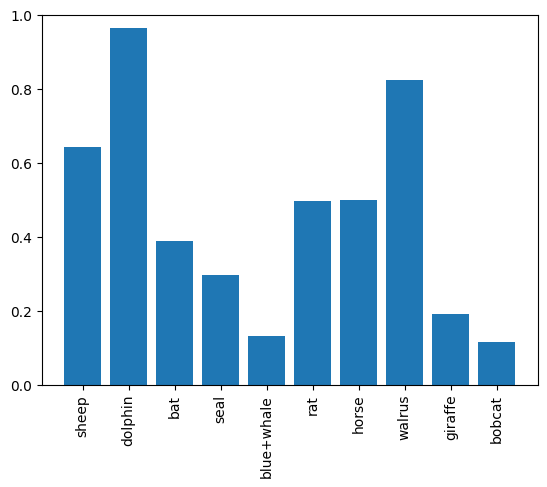

In [35]:
print("acc count:", (results==test_labels).sum())
print("acc count:", len(test_labels))
acc_dict, test_dict = {}, {}
for test_value in test_values:
    acc_dict[test_value] = test_dict[test_value] = 0
for pred, value in zip(results, test_labels):
    test_dict[value] += 1
    if pred == value:
        acc_dict[value] += 1

print("acc:", acc_dict)
print("test:", test_dict)

rate = []
acc_count = 0
for value in test_values:
    rate.append(acc_dict[value]/test_dict[value])
    acc_count += acc_dict[value]
canvas = plt.figure()
plt.cla()
plt.bar(test_names, rate)
plt.ylim(0,1)
plt.xticks(rotation=90)

